In [49]:
from numpy.random import seed
seed(1)

In [ ]:
!pip3 install nltk

Note: Due to GPU-related randomness, the training will not be reproducible.

In [52]:
import keras
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(10)
from preprocess_utils import pre_processing as stopwords_stemmer

[nltk_data] Downloading package stopwords to /home/mbc7bu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mbc7bu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load dataset from csv file.

In [54]:

df = pd.read_csv('./fake_or_real_news.csv')
df['merged_text'] = df['title'] + '. ' + df['text']
df['processed_text'] = stopwords_stemmer(df['merged_text'])
df.loc[df['label'] == 'REAL', 'target'] = 0
df.loc[df['label'] == 'FAKE', 'target'] = 1

df_pick = df[['processed_text', 'target']]
df.head()

,Unnamed: 0,title,text,label,merged_text,processed_text,target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear. Daniel Greenfiel...,you can smell hillari ’ fear . daniel greenfie...,1.0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch the exact moment paul ryan commit polit ...,1.0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy. U...,kerri go pari gestur sympathi . u.s. secretari...,0.0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,berni support twitter erupt anger dnc : 'we tr...,1.0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,the battl new york : whi thi primari matter . ...,0.0


#### Load data as train and test data.   
  a. Add Title to Text and create the final text, label ordered pair.  
  b. Split the data 80-20 into train and test datasets.

In [55]:
training_data = df_pick.sample(frac=0.8, random_state=25)
testing_data = df_pick.drop(training_data.index)

print(training_data.shape)
print(testing_data.shape)

(5068, 2)
(1267, 2)


In [56]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_data['processed_text'].values, tf.string),
            tf.cast(training_data['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(testing_data['processed_text'].values, tf.string),
            tf.cast(testing_data['target'].values, tf.int32)
        )
    )
)
BUFFER_SIZE = 10000
BATCH_SIZE = 8
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

This is one training example in the dataset.

In [57]:
for example, label in training_dataset.take(1):
  print('texts: ', example.numpy()[:1])
  print('labels: ', label.numpy()[:1])

texts:  [b'\xe2\x80\x98 peopl europ full fear \xe2\x80\x99 refuge influx . the european union \xe2\x80\x99 sharpen divis spiral refuge crisi broke open thursday two leader strongli disagre public whether asylum-seek threaten \xe2\x80\x9c europ \xe2\x80\x99 christian roots. \xe2\x80\x9d that languag use hungarian prime minist viktor orban warn europ allow mostli muslim famili . a day drown syrian toddler wash turkish coast , anoth european leader retort christian valu demand help less fortun . the furiou exchang \xe2\x80\x94 rare breach e.u. \xe2\x80\x99 buttoned-down decorum \xe2\x80\x94 came hungarian author appar laid trap thousand asylum-seek pack budapest \xe2\x80\x99 central train station day worsen condit outsid station . polic block enter station day allow earli thursday . but refugee-pack train appar bound austrian border came halt west budapest , small town dozen polic offic wait platform . they tri forc peopl train take migrant-process center , threaten chanc make onward west

Note VOCAB_SIZE as a hyper-parameter. Next we create the Encoder layer that will encode every word in vocabulary as a vector.

#### Define the Encoder layer

In [58]:
VOCAB_SIZE = 2000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [59]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '’', '“', '”', 'the', 'trump', 'i', 'said', 's',
       'clinton', 'state', 'would', 'us', 'one', 'peopl', 'new', 'presid',
       'it', 'republican'], dtype='<U13')

In [60]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 125,   15,  758, ...,  684,    1, 1061],
       [   1,    1,  711, ...,    0,    0,    0],
       [ 682, 1211,    1, ...,    0,    0,    0]])

### Specify the model architecture
Layers:
1. Encoder
2. Embedding
3. LSTM
4. Dense layer
5. Output layer

In [61]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Sample prediction on untrained model

In [62]:
sample_text = ('''Poll: 71 percent of Dems think Clinton should keep running even if indicted. A strong majority of Democratic voters think Hillary 
               Clinton should keep running for president even if she is charged with 
               a felony in connection with her private email use while secretary of state, according to a new poll.''')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00121727]


### Training the model
First, we specify the loss, optimizer, and metrics for the training phase.

In [64]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

To implement Early Stopping, we monitor the Validation loss and do not stop training unless it doesn't decrease below current lowest for 7 epochs. Once it has stopped, we restore the model to its best weights according to the validation loss.

In [65]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(training_dataset, epochs=20, callbacks = [callback],
                    validation_data=test_dataset)

Epoch 1/20
634/634 [==============================] - 29s 41ms/step - loss: 0.5931 - accuracy: 0.6178 - val_loss: 0.3797 - val_accuracy: 0.8461
Epoch 2/20
634/634 [==============================] - 25s 40ms/step - loss: 0.3653 - accuracy: 0.8530 - val_loss: 0.3039 - val_accuracy: 0.8871
Epoch 3/20
634/634 [==============================] - 26s 40ms/step - loss: 0.2704 - accuracy: 0.9029 - val_loss: 0.2572 - val_accuracy: 0.9092
Epoch 4/20
634/634 [==============================] - 25s 40ms/step - loss: 0.2274 - accuracy: 0.9274 - val_loss: 0.2654 - val_accuracy: 0.9092
Epoch 5/20
634/634 [==============================] - 25s 40ms/step - loss: 0.2220 - accuracy: 0.9294 - val_loss: 0.2535 - val_accuracy: 0.9155
Epoch 6/20
634/634 [==============================] - 25s 40ms/step - loss: 0.1737 - accuracy: 0.9434 - val_loss: 0.2140 - val_accuracy: 0.9266
Epoch 7/20
634/634 [==============================] - 25s 40ms/step - loss: 0.1540 - accuracy: 0.9491 - val_loss: 0.2724 - val_accuracy:

### Results

In [66]:
def plot_graphs(history, metric):
    """Utility function to plot the graphs"""
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

The plots below show the training accuracy and loss alongside the validation (here, validation set is the test set itself) accuracy and loss, plotted against the epoch number.

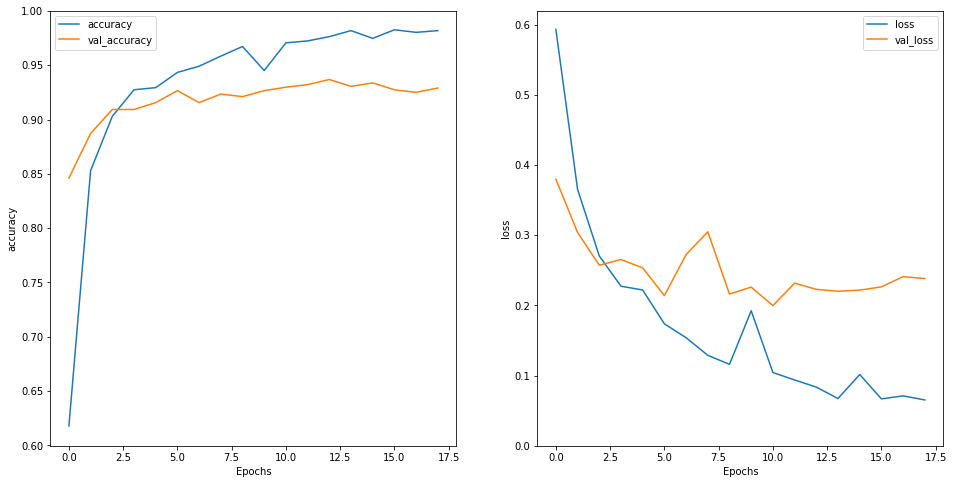

In [67]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig('plots/LSTM/LSTM_training')

### Test Loss and Accuracy of the trained LSTM classifier.

In [69]:
loss, accuracy =model.evaluate(test_dataset)
results = dict(loss = loss, accuracy=accuracy)
import pickle
with open('outputs/LSTM_results.pkl', 'wb') as fout:
    pickle.dump(results, fout)
print(f'Test accuracy: {accuracy}\nTest loss: {loss}')

159/159 [==============================] - 3s 16ms/step - loss: 0.1998 - accuracy: 0.9298
Test accuracy: 0.9297553300857544
Test loss: 0.1997651606798172
